# RL Course by David Silver

## Lecture 8 : Integrating Learning and Planning

Dyna-Q Algorithm
<img src="img/Dyna-Q.png" width="70%"></img>
Example: Dyna-Q on a Simple Maze
<img src="img/SimpleMaze.png"></img>

In [1]:
%matplotlib inline
import pdb
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict, deque, Counter
from mpl_toolkits.mplot3d import Axes3D

### 实现迷宫游戏环境
首先定义迷宫的格子`Grid`，它具有三个属性
+ `isPassable` 表示格子是否允许通过
+ `isTerminate` 表示该格子是否为终止状态
+ `reward` 表示走到该格子上的即时奖励
---
之后用一个格子组成的二维数组构成迷宫`SimpleMaze`，这个类提供了两个方法
+ `move()`接受一个状态 $S$ 和动作 $A$，返回即时奖励 $R$ 和下一个状态 $S'$
+ `isTerminate()`接受一个状态，并判断其是否为终止状态

In [2]:
class Grid(object):
    '''One single grid in the maze.
    '''

    def __init__(self, isPassable=True, isTerminate=False, reward=0):
        self.__isPassable = isPassable
        self.__isTerminate = isTerminate
        self.__reward = reward

    def toTuple(self):
        return (self.__isPassable, self.__isTerminate, self.__reward)


class SimpleMaze(object):
    '''Simple Maze game.
    '''
    __move = {
        'n': np.asarray([-1, 0]),
        's': np.asarray([1, 0]),
        'w': np.asarray([0, -1]),
        'e': np.asarray([0, 1])
    }
    directions = ('e', 'w', 'n', 's')

    def __init__(self, Map, start_position):
        self.__map = Map.copy()
        self.__map_width = Map.shape[1]
        self.__map_height = Map.shape[0]
        self.start_position = start_position

    def __grid_at(self, position):
        return self.__map[position[0], position[1]]

    def move(self, position, move_direction):
        next_position = position + SimpleMaze.__move[move_direction]
        # horizontal boundary check
        if (next_position[1] < 0 or next_position[1] >= self.__map_width):
            next_position = position
        # vertical boundary check
        elif (next_position[0] < 0 or next_position[0] >= self.__map_height):
            next_position = position
        # barrier check
        elif self.__grid_at(next_position)['isPassable'] == False:
            next_position = position
        reward = -1 + self.__grid_at(next_position)['reward']
        return reward, next_position

    def is_terminate(self, position):
        return self.__grid_at(position)['isTerminate'] == True

    def get_map_shape(self):
        return self.__map_height, self.__map_width


class MDP_for_SimpleMaze(object):
    '''MDP wrapper for Simple Maze game.
    '''

    def __init__(self, Map, start_position):
        self.__game = SimpleMaze(Map, start_position)
        self.action_space_shape = 4
        self.reset()

    def get_state(self):
        return self.state

    def act(self, action):
        '''Take actions in a MDP.
        
        Args:
            action
        Returns:
            reward
            next state
        '''
        position = np.asarray(self.state)
        move_direction = self.__game.directions[action]
        reward, next_position = self.__game.move(position, move_direction)
        self.is_terminate = self.__game.is_terminate(next_position)
        self.state = tuple(next_position)
        return reward, self.state

    def reset(self):
        self.is_terminate = False
        self.state = tuple(self.__game.start_position)
        return self.state

### 策略改进方法

In [3]:
def improve_greedy_policy(Q):
    def policy(state):
        if Q[state].max() == Q[state].min():
            action = np.random.randint(0, len(Q[state]))
        else:
            action = np.argmax(Q[state])
        return action

    return policy


def improve_epsilon_greedy_policy(Q, epsilon):
    p = np.random.uniform()
    if p > epsilon:
        return improve_greedy_policy(Q)
    else:
        return lambda s: np.random.randint(0, len(Q[s]))

### 实现Sarsa算法

In [4]:
def Sarsa(MDP, episodes, alpha=0.1, gamma=0.5, epsilon=0.05):
    episode = 0
    steps = 0
    convergence = []
    # initialize Q(S, A)
    Q = defaultdict(lambda: np.zeros(MDP.action_space_shape))
    # start iteration
    while episode < episodes:
        state = MDP.reset()
        policy = improve_greedy_policy(Q)
        action = policy(state)
        while not MDP.is_terminate:
            reward, next_state = MDP.act(action)
            next_action = policy(next_state)
            Q[state][action] += alpha * (
                reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            steps += 1
        convergence.append(steps)
        steps = 0
        episode += 1
    return convergence, Q

### 实现Dyna-Q算法

In [5]:
class MDP_model(object):
    '''A model of MDP to be learned from real experience.
    '''

    def __init__(self):
        self._transitions = defaultdict(lambda: defaultdict(
            lambda: defaultdict(float)))
        self._rewards = defaultdict(lambda: defaultdict(float))
        self._visit_counter = defaultdict(Counter)

    def learn(self, state, action, next_state, reward):
        """Learn transition probabilities and rewards from a MDP.
        
        Args:
            state
            action
            next_state
            reward
        """
        self._visit_counter[state][action] += 1
        self._rewards[state][action] += (reward - self._rewards[state][action]
                                         ) / self._visit_counter[state][action]

        for k in self._transitions[state][action]:
            self._transitions[state][action][
                k] *= 1 - 1 / self._visit_counter[state][action]
        self._transitions[state][action][
            next_state] += 1 / self._visit_counter[state][action]

    def generate(self, state, action):
        """Generate next state and reward according to learned model.
        
        Args:
            state
            action
            
        Returns:
            next_state
            reward
        """
        prob = np.random.uniform()
        for k, v in self._transitions[state][action].items():
            if prob - v < 0:
                next_state = k
            else:
                prob -= v
        return next_state, self._rewards[state][action]

In [6]:
def Dyna_Q(MDP, episodes, planning_steps, alpha=0.1, gamma=0.5, epsilon=0.05):
    episode = 0
    planning_step = 0
    steps = 0
    convergence = list()
    # initialize Q(S,A) and Model(S,A)
    Q = defaultdict(lambda: np.zeros(MDP.action_space_shape))
    model = MDP_model()
    while episode < episodes:
        state = MDP.reset()
        memory = list()
        while not MDP.is_terminate:
            policy = improve_greedy_policy(Q)
            action = policy(state)
            memory.append((state, action))
            reward, next_state = MDP.act(action)
            Q[state][action] += alpha * (
                reward + gamma * Q[next_state].max() - Q[state][action])
            model.learn(state, action, next_state, reward)
            state = next_state
            # planning with model
            while planning_step < planning_steps:
                p_state, p_action = memory[np.random.randint(0, len(memory))]
                p_next_state, p_reward = model.generate(p_state, p_action)
                Q[p_state][p_action] += alpha * (
                    reward + gamma * Q[p_next_state].max() -
                    Q[p_state][p_action])
                planning_step += 1
            planning_step = 0
            steps += 1
        convergence.append(steps)
        steps = 0
        episode += 1
    return convergence, Q

In [7]:
def plot_convergence(convergence, title, fig=None):
    if fig == None:
        fig = plt.figure(figsize=(8, 6))
        fig.clear()
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(121)
    x = np.arange(0, len(convergence))
    y = np.asarray(convergence)
    ax.plot(x, y)
    ax.set_xlabel("Num of episodes")
    ax.set_ylabel("Steps per episode")
    ax.set_title("Convergence")
    fig.suptitle(title)


def plot_result(convergence, Q, title):
    fig = plt.figure(figsize=(14, 9))
    fig.clear()
    plot_convergence(convergence, title, fig)
    V = defaultdict(float)
    for k in Q:
        V[k] = Q[k].max()
    max_x = max(k[0] for k in Q)
    min_x = min(k[0] for k in Q)
    max_y = max(k[1] for k in Q)
    min_y = min(k[1] for k in Q)
    X = np.arange(min_x, max_x + 1)
    Y = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(X, Y)
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="viridis")
    ax.set_xlabel("X axis of maze")
    ax.set_ylabel("Y axis of maze")
    ax.set_zlabel("Values")
    ax.set_title("Maze Grid Values")

### 定义迷宫的大小、出口、障碍物等相关参数

In [8]:
# parameters
Maze_Width = 9
Maze_Height = 6
Terminate_Positions = ([0, 8], )
Barrier_Positions = ([1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5])
Start_Position = [3, 0]

# initialize maze map
normal_grid = Grid()
barrier_grid = Grid(isPassable=False)
terminate_grid = Grid(isTerminate=True, reward=0)
grid_type = np.dtype([('isPassable', 'b'), ('isTerminate', 'b'),
                      ('reward', 'i1')])
Map = np.zeros([Maze_Height, Maze_Width], dtype=grid_type)
Map.fill(normal_grid.toTuple())
for pos in Terminate_Positions:
    Map[pos[0], pos[1]] = terminate_grid.toTuple()
for pos in Barrier_Positions:
    Map[pos[0], pos[1]] = barrier_grid.toTuple()

In [9]:
alpha = 0.3
maze = MDP_for_SimpleMaze(Map, Start_Position)

In [10]:
convergence_0, Q_0 = Sarsa(MDP=maze, episodes=100, alpha=alpha)

In [11]:
convergence_1, Q_1 = Dyna_Q(MDP=maze, episodes=100, planning_steps=5, alpha=alpha)

In [12]:
convergence_2, Q_2 = Dyna_Q(MDP=maze, episodes=100, planning_steps=50, alpha=alpha)

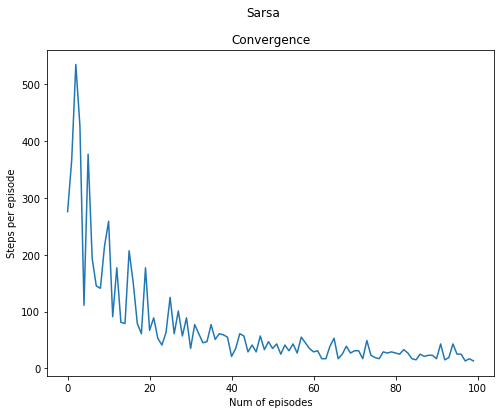

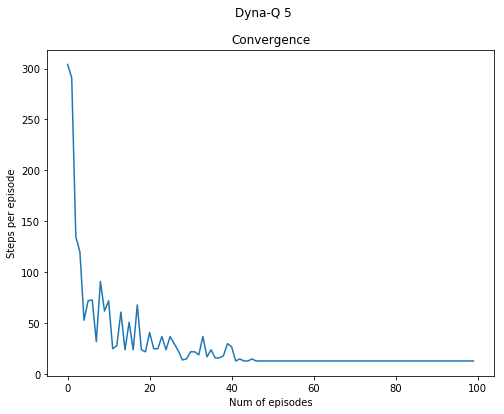

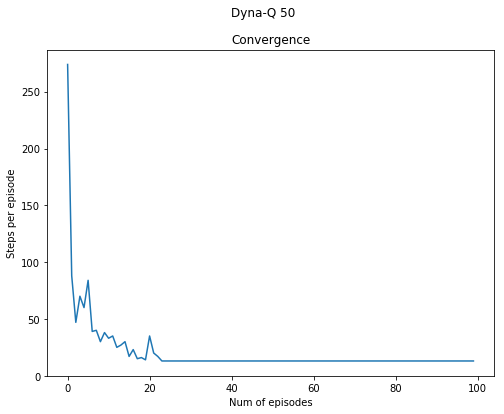

In [13]:
plot_convergence(convergence_0, "Sarsa")
plot_convergence(convergence_1, "Dyna-Q 5")
plot_convergence(convergence_2, "Dyna-Q 50")